In [1]:
# packages required for new environment
# ! pip install pandas
# ! pip install nltk
# ! pip install datasets
# ! pip install tqdm
# ! pip install ipywidgets
# ! pip install Pillow

In [2]:
#Libraries
import pandas as pd
import numpy as np
import datasets
import nltk
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import keras
from keras import layers
from tensorflow.keras import regularizers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 10
EPOCHS = 30
LR = 1e-3

# Dataset 1

In [3]:
# 1. tiny-imagenet
#   (a) Dataset Summary - Tiny ImageNet contains 100,000+ images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images.
#   (b) Data Feature Dimensions -
#       i. Image: A PIL.Image.Image object containing the image.
#       ii. Label: an int classification label. -1 for the test set as the labels are missing. Check classes.py for the map of numbers and labels.

In [4]:
# # Retrieve data directly from Stanford data source
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip -qq 'tiny-imagenet-200.zip'
# DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# # Define training and validation data paths
# TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
# VALID_DIR = os.path.join(DATA_DIR, 'val')

In [5]:
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')
random.seed(42)

# get all class id and label from words.txt
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for id, line in enumerate(data):
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

In [6]:
# Training datset creation 
tiny_imagenet_train = pd.DataFrame()
for root, directories, files in os.walk(TRAIN_DIR):
    for directory in directories:
        d = pd.read_csv(os.path.join(root,directory, directory + "_boxes.txt"), 
                       sep='\t', 
                       header=None, 
                       names=['File', 'X', 'Y', 'H', 'W'])
        tiny_imagenet_train = pd.concat([tiny_imagenet_train,d])
    break
tiny_imagenet_train["Class"]=tiny_imagenet_train.apply(lambda row: row.File.split('_')[0], axis=1)
tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: os.path.join(root, row.Class ,"images", row.File), axis=1)
# tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: load_image(os.path.join(root, row.Class ,"images", row.File)), axis=1)
tiny_imagenet_train['label_name']=tiny_imagenet_train.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.sample(frac=1).reset_index(drop=True)
tiny_imagenet_train

File   X   Y   H   W  \
0      tiny-imagenet-200/train/n04023962/images/n0402...  23   0  39  38   
1      tiny-imagenet-200/train/n03255030/images/n0325...   0  30  63  56   
2      tiny-imagenet-200/train/n02802426/images/n0280...  35  28  45  38   
3      tiny-imagenet-200/train/n04179913/images/n0417...   0   5  63  62   
4      tiny-imagenet-200/train/n07749582/images/n0774...  14   9  50  59   
...                                                  ...  ..  ..  ..  ..   
99995  tiny-imagenet-200/train/n02788148/images/n0278...   0   3  63  33   
99996  tiny-imagenet-200/train/n03770439/images/n0377...  23  40  39  56   
99997  tiny-imagenet-200/train/n03255030/images/n0325...   5   5  63  57   
99998  tiny-imagenet-200/train/n02788148/images/n0278...   2   0  49  63   
99999  tiny-imagenet-200/train/n03970156/images/n0397...  31   2  42  32   

           Class      label_name  
0      n04023962    punching bag  
1      n03255030        dumbbell  
2      n02802426      basketball  
3      n04179913  sewing machine  
4      n07749582           lemon  
...          ...             ...  
99995  n02788148       bannister  
99996  n03770439       miniskirt  
99997  n03255030        dumbbell  
99998  n02788148       bannister  
99999  n03970156         plunger  

[100000 rows x 7 columns]

In [7]:
class_to_label_number_dict = dict()
unique_train_class = tiny_imagenet_train.Class.value_counts().keys()
for idx, Class in enumerate(unique_train_class):
    class_to_label_number_dict[Class] = idx
label_number_to_class = {y : x for x, y in class_to_label_number_dict.items()}

In [8]:
# Validation dataset creation 

# Display first 20 entries of resulting dictionary
tiny_imagenet_valid = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

# attaching label to respective class 
tiny_imagenet_valid["label_name"] = tiny_imagenet_valid.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
# tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: load_image(os.path.join(VALID_DIR,"images", row.File)), axis=1)
tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: os.path.join(VALID_DIR,"images", row.File), axis=1)
tiny_imagenet_valid = tiny_imagenet_valid.sample(frac=1).reset_index(drop=True)
tiny_imagenet_valid

File      Class   X   Y   H   W  \
0     tiny-imagenet-200/val/images/val_9073.JPEG  n02917067   8  13  57  52   
1     tiny-imagenet-200/val/images/val_5400.JPEG  n02364673   0   0  63  63   
2     tiny-imagenet-200/val/images/val_1760.JPEG  n09332890   0  40  63  61   
3       tiny-imagenet-200/val/images/val_43.JPEG  n02231487  25   7  46  47   
4     tiny-imagenet-200/val/images/val_7604.JPEG  n02481823   0   0  63  63   
...                                          ...        ...  ..  ..  ..  ..   
9995  tiny-imagenet-200/val/images/val_5483.JPEG  n02125311  20  11  63  62   
9996  tiny-imagenet-200/val/images/val_2112.JPEG  n03902125   0  12  35  63   
9997  tiny-imagenet-200/val/images/val_9794.JPEG  n01855672  14  13  53  50   
9998  tiny-imagenet-200/val/images/val_9228.JPEG  n02486410   3   0  55  51   
9999  tiny-imagenet-200/val/images/val_6247.JPEG  n02802426  45   5  51  11   

         label_name  
0      bullet train  
1        guinea pig  
2          lakeside  
3     walking stick  
4        chimpanzee  
...             ...  
9995         cougar  
9996      pay-phone  
9997          goose  
9998         baboon  
9999     basketball  

[10000 rows x 7 columns]

In [9]:

limited_classes = list(class_to_label_number_dict.keys())[:NUM_CLASSES]
train_drop_index = tiny_imagenet_train[~tiny_imagenet_train.Class.isin(limited_classes)].index
valid_drop_index = tiny_imagenet_valid[~tiny_imagenet_valid.Class.isin(limited_classes)].index

tiny_imagenet_valid.drop( valid_drop_index, inplace=True)
tiny_imagenet_train.drop( train_drop_index, inplace=True)

tiny_imagenet_train['label_number']=tiny_imagenet_train.apply(lambda row: class_to_label_number_dict[row.Class], axis= 1)
tiny_imagenet_valid['label_number']=tiny_imagenet_valid.apply(lambda row: class_to_label_number_dict[row.Class], axis= 1)

tiny_imagenet_train

File   X   Y   H   W  \
0      tiny-imagenet-200/train/n04023962/images/n0402...  23   0  39  38   
56     tiny-imagenet-200/train/n04023962/images/n0402...  45   0  63  32   
118    tiny-imagenet-200/train/n04023962/images/n0402...  12   6  33  63   
202    tiny-imagenet-200/train/n01629819/images/n0162...  32  15  63  41   
211    tiny-imagenet-200/train/n02437312/images/n0243...   0   6  63  63   
...                                                  ...  ..  ..  ..  ..   
99918  tiny-imagenet-200/train/n04023962/images/n0402...   0   0   8  63   
99932  tiny-imagenet-200/train/n04597913/images/n0459...  14  10  63  63   
99962  tiny-imagenet-200/train/n01629819/images/n0162...   0  23  61  47   
99981  tiny-imagenet-200/train/n03804744/images/n0380...   0  16   0  50   
99982  tiny-imagenet-200/train/n04023962/images/n0402...   0  17  11  63   

           Class                label_name  label_number  
0      n04023962              punching bag             0  
56     n04023962              punching bag             0  
118    n04023962              punching bag             0  
202    n01629819  European fire salamander             2  
211    n02437312             Arabian camel             3  
...          ...                       ...           ...  
99918  n04023962              punching bag             0  
99932  n04597913              wooden spoon             1  
99962  n01629819  European fire salamander             2  
99981  n03804744                      nail             7  
99982  n04023962              punching bag             0  

[5000 rows x 8 columns]

In [10]:
def augment_image(image):
    """Apply data augmentation techniques to the image."""
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    
    # Randomly adjust the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Random erasing (using a random crop and pad as a proxy)
    if tf.random.uniform(()) > 0.75:  # 25% chance to apply erasing
        erase_size = tf.random.uniform(shape=[], minval=20, maxval=100, dtype=tf.int32)
        erase_value = 0  # You can set this to random or a specific pixel value
        pad_size = 224 - erase_size
        image = tf.image.resize_with_crop_or_pad(image, erase_size, erase_size)  # Crop
        image = tf.image.resize_with_crop_or_pad(image, 224, 224)  # Pad
        image = tf.where(image == 0, erase_value, image)  # Apply erasing

    return image

def load_and_preprocess_augument_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.uint8)
    
    # Apply augmentation with 50% probability
    augmented_image = tf.cond(
        tf.random.uniform((), 0, 1) > 0.5,
        lambda: augment_image(image),
        lambda: image
    )
    
    label = tf.one_hot(label, NUM_CLASSES)
    return augmented_image, label

def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)  # Ensure image data type is uint8
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# creating train dataset loader
image = tf.convert_to_tensor(tiny_imagenet_train.File.values)
labels = tiny_imagenet_train.label_number.values
ds_train = tf.data.Dataset.from_tensor_slices((image, labels))

ds_train = ds_train.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

image = tf.convert_to_tensor(tiny_imagenet_train.File.values)
labels = tiny_imagenet_train.label_number.values
ds_train_augumented = tf.data.Dataset.from_tensor_slices((image, labels))
ds_train_augumented = ds_train_augumented.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train_augumented = ds_train_augumented.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train_augumented = ds_train_augumented.prefetch(tf.data.AUTOTUNE)

# creating valid dataset loader
image = tf.convert_to_tensor(tiny_imagenet_valid.File.values)
labels = tiny_imagenet_valid.label_number.values
ds_valid = tf.data.Dataset.from_tensor_slices((image, labels))

ds_valid = ds_valid.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

image = tf.convert_to_tensor(tiny_imagenet_valid.File.values)
labels = tiny_imagenet_valid.label_number.values
ds_valid_augumented = tf.data.Dataset.from_tensor_slices((image, labels))
ds_valid_augumented = ds_valid_augumented.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid_augumented = ds_valid_augumented.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_valid_augumented = ds_valid_augumented.prefetch(tf.data.AUTOTUNE)

In [11]:
# input size
print(ds_train.element_spec)

(TensorSpec(shape=(64, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(64, 10), dtype=tf.float32, name=None))


Image shape: (64, 224, 224, 3)


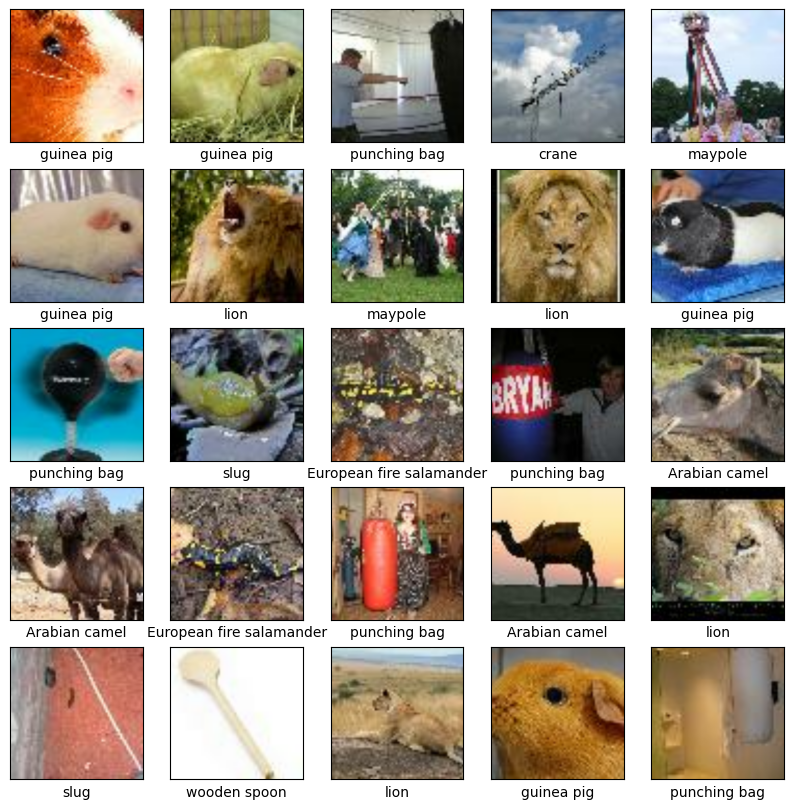

In [12]:
# Take one element from the dataset
sample = ds_valid.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(class_to_name_dict[label_number_to_class[np.argmax(label[i])]])
    plt.show()
    break



Image shape: (64, 224, 224, 3)


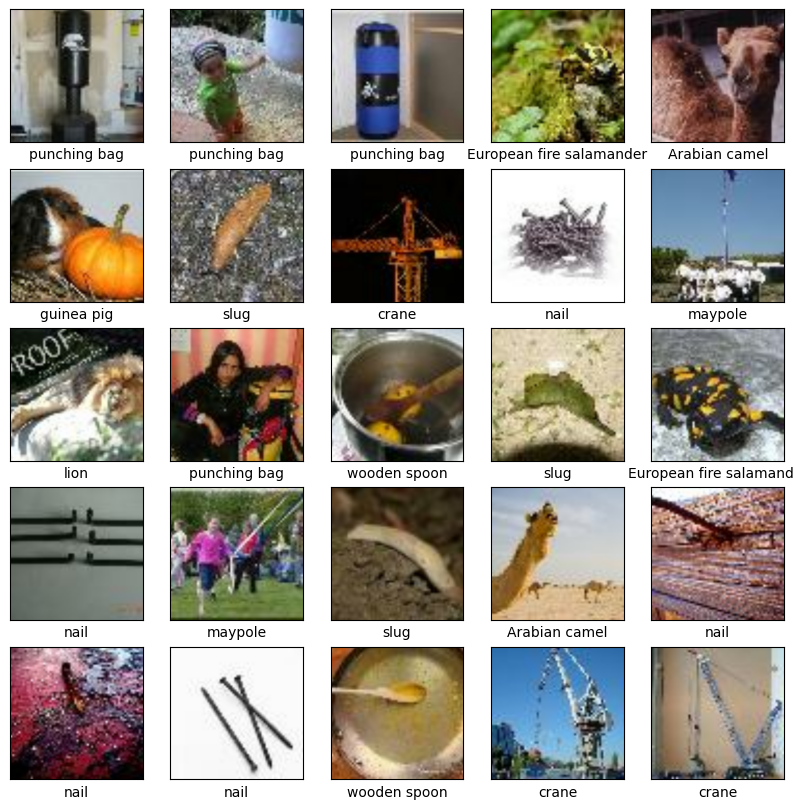

In [13]:
# Take one element from the dataset
sample = ds_train.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(class_to_name_dict[label_number_to_class[np.argmax(label[i])]])
    plt.show()
    break



Image shape: (64, 224, 224, 3)


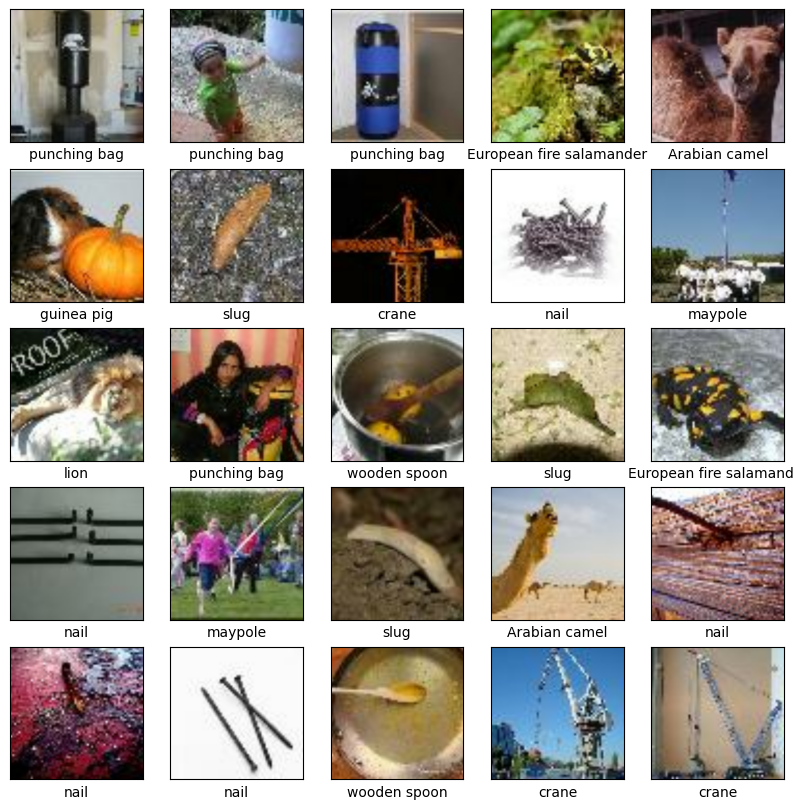

In [14]:
# Take one element from the dataset
sample = ds_train_augumented.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(class_to_name_dict[label_number_to_class[np.argmax(label[i])]])
    plt.show()
    break

Image shape: (64, 224, 224, 3)


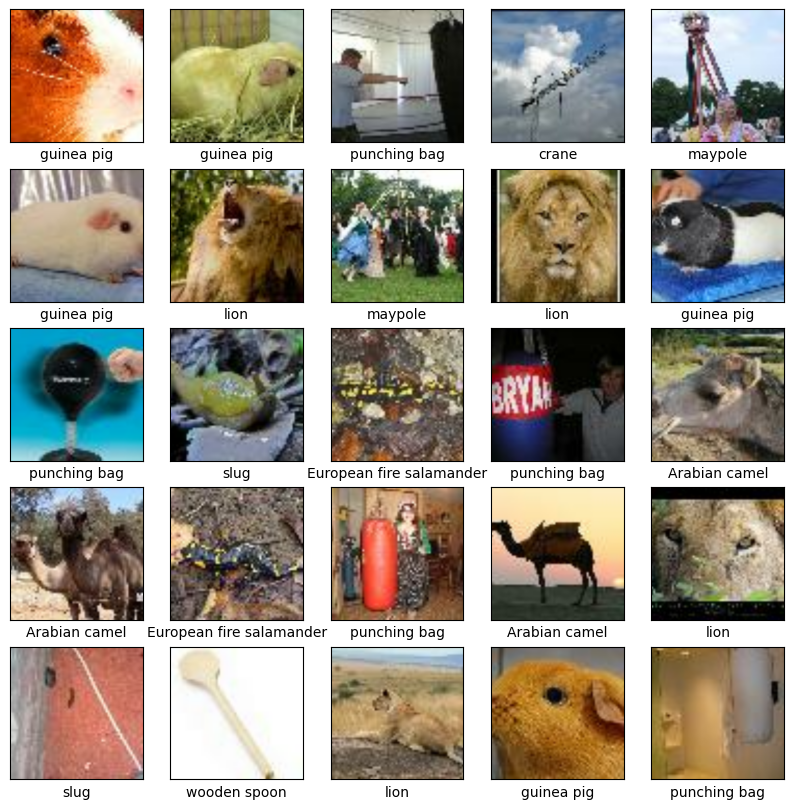

In [15]:
# Take one element from the dataset
sample = ds_valid_augumented.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(class_to_name_dict[label_number_to_class[np.argmax(label[i])]])
    plt.show()
    break

In [16]:
def efficientNetB0_model(num_classes, dropout, l2):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    if( dropout ):
        top_dropout_rate = 0.2
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    if (l2):
        outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.00002))(x)
    else:
        outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 766ms/step - accuracy: 0.7564 - loss: 0.9750 - val_accuracy: 0.8661 - val_loss: 0.4320
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 58s 739ms/step - accuracy: 0.9046 - loss: 0.3764 - val_accuracy: 0.8772 - val_loss: 0.4319
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 59s 758ms/step - accuracy: 0.9220 - loss: 0.2836 - val_accuracy: 0.8862 - val_loss: 0.4172
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 777ms/step - accuracy: 0.9437 - loss: 0.1825 - val_accuracy: 0.8906 - val_loss: 0.5781
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 59s 752ms/step - accuracy: 0.9520 - loss: 0.1624 - val_accuracy: 0.8906 - val_loss: 0.5748
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 57s 731ms/step - accuracy: 0.9639 - loss: 0.1117 - val_accuracy: 0.8705 - val_loss: 0.7639
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 57s 731ms/step - accuracy: 0.9601 - loss: 0.1480 - val_accuracy: 0.8772 - val_loss: 0.7406
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 56s 720ms/step - accuracy: 0.9578 - loss: 0.1568 - val_accu

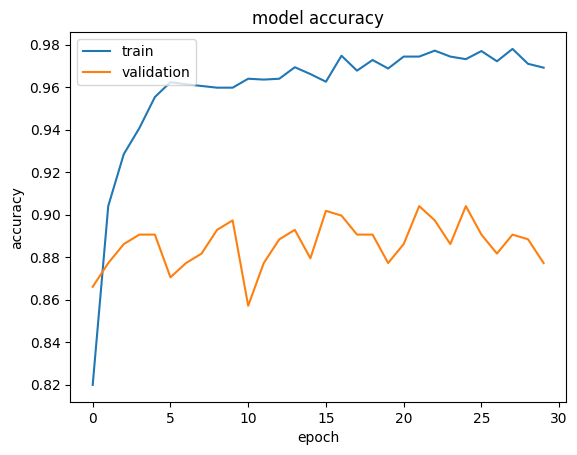

In [17]:
model_baseline = efficientNetB0_model(num_classes=NUM_CLASSES, dropout=False, l2=False )
model_baseline_output = model_baseline.fit(ds_train, epochs=EPOCHS, validation_data=ds_valid)
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
plot_hist(model_baseline_output)


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 734ms/step - accuracy: 0.7460 - loss: 1.0159 - val_accuracy: 0.8728 - val_loss: 0.3958
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 60s 767ms/step - accuracy: 0.8869 - loss: 0.4944 - val_accuracy: 0.8996 - val_loss: 0.3267
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 67s 865ms/step - accuracy: 0.9015 - loss: 0.3535 - val_accuracy: 0.9107 - val_loss: 0.3940
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 834ms/step - accuracy: 0.9204 - loss: 0.2913 - val_accuracy: 0.8973 - val_loss: 0.4786
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 815ms/step - accuracy: 0.9207 - loss: 0.2888 - val_accuracy: 0.9040 - val_loss: 0.4885
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 786ms/step - accuracy: 0.9229 - loss: 0.2777 - val_accuracy: 0.8884 - val_loss: 0.6574
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 63s 811ms/step - accuracy: 0.9315 - loss: 0.2511 - val_accuracy: 0.8996 - val_loss: 0.6305
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 831ms/step - accuracy: 0.9418 - loss: 0.2404 - val_accu

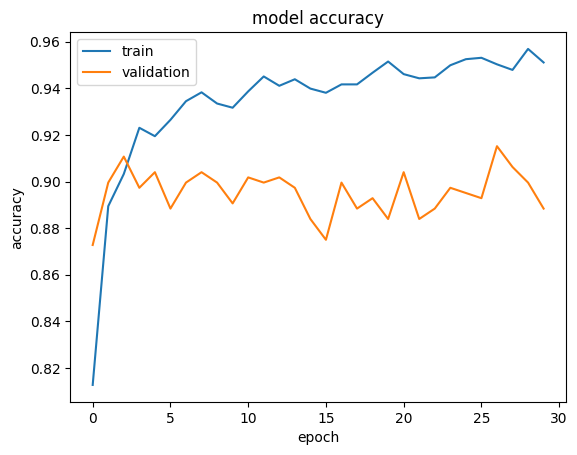

In [18]:
model_dropout = efficientNetB0_model(num_classes=NUM_CLASSES, dropout=True, l2=False )
model_dropout_output = model_dropout.fit(ds_train, epochs=EPOCHS, validation_data=ds_valid)
plot_hist(model_dropout_output)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 72s 864ms/step - accuracy: 0.7462 - loss: 0.9842 - val_accuracy: 0.8616 - val_loss: 0.4398
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 68s 876ms/step - accuracy: 0.8939 - loss: 0.4422 - val_accuracy: 0.8817 - val_loss: 0.4028
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 853ms/step - accuracy: 0.9354 - loss: 0.2316 - val_accuracy: 0.8929 - val_loss: 0.3974
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 70s 892ms/step - accuracy: 0.9377 - loss: 0.1956 - val_accuracy: 0.8929 - val_loss: 0.5630
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 68s 872ms/step - accuracy: 0.9503 - loss: 0.1693 - val_accuracy: 0.8973 - val_loss: 0.5801
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 69s 883ms/step - accuracy: 0.9521 - loss: 0.1760 - val_accuracy: 0.8951 - val_loss: 0.5871
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 69s 890ms/step - accuracy: 0.9547 - loss: 0.1439 - val_accuracy: 0.8884 - val_loss: 0.6834
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 823ms/step - accuracy: 0.9581 - loss: 0.1439 - val_accu

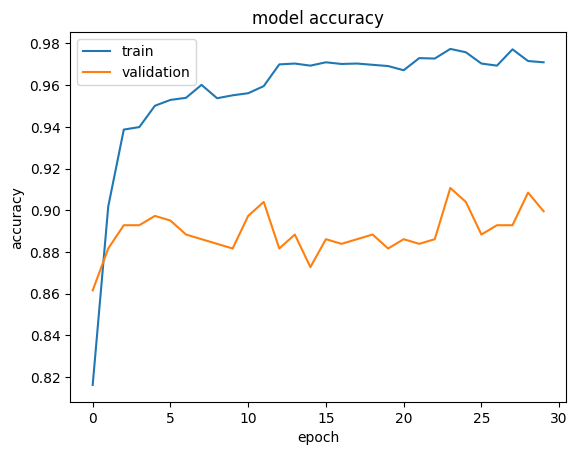

In [19]:
model_l2 = efficientNetB0_model(num_classes=NUM_CLASSES, dropout=False, l2=True )
model_l2_output = model_l2.fit(ds_train, epochs=EPOCHS, validation_data=ds_valid)
plot_hist(model_l2_output)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 785ms/step - accuracy: 0.7415 - loss: 1.0334 - val_accuracy: 0.8772 - val_loss: 0.4199
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 782ms/step - accuracy: 0.8815 - loss: 0.5123 - val_accuracy: 0.8772 - val_loss: 0.4199
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 60s 773ms/step - accuracy: 0.8989 - loss: 0.3880 - val_accuracy: 0.8839 - val_loss: 0.5441
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 60s 774ms/step - accuracy: 0.9080 - loss: 0.3680 - val_accuracy: 0.9085 - val_loss: 0.4542
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 60s 771ms/step - accuracy: 0.9182 - loss: 0.3060 - val_accuracy: 0.9040 - val_loss: 0.5683
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 60s 771ms/step - accuracy: 0.9231 - loss: 0.2943 - val_accuracy: 0.9040 - val_loss: 0.5157
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 60s 776ms/step - accuracy: 0.9286 - loss: 0.2760 - val_accuracy: 0.8839 - val_loss: 0.7789
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 779ms/step - accuracy: 0.9255 - loss: 0.3183 - val_accu

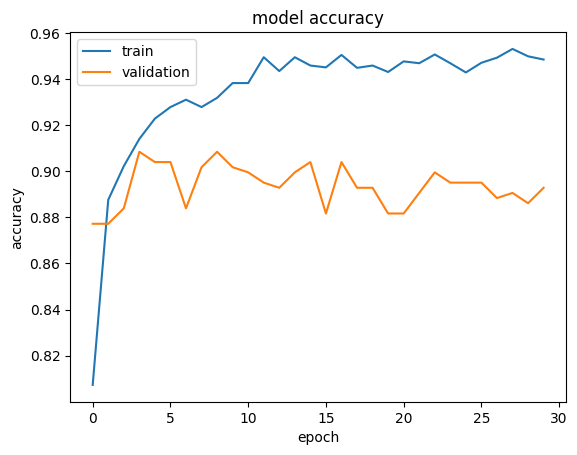

In [20]:
model_ensemble = efficientNetB0_model(num_classes=NUM_CLASSES, dropout=True, l2=True )
model_ensemble_output = model_ensemble.fit(ds_train, epochs=EPOCHS, validation_data=ds_valid)
plot_hist(model_ensemble_output)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 71s 856ms/step - accuracy: 0.7509 - loss: 0.9809 - val_accuracy: 0.8817 - val_loss: 0.3670
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 69s 882ms/step - accuracy: 0.9002 - loss: 0.3603 - val_accuracy: 0.8929 - val_loss: 0.3683
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 63s 804ms/step - accuracy: 0.9293 - loss: 0.2482 - val_accuracy: 0.9062 - val_loss: 0.4016
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 788ms/step - accuracy: 0.9357 - loss: 0.2180 - val_accuracy: 0.9107 - val_loss: 0.4279
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 796ms/step - accuracy: 0.9463 - loss: 0.1763 - val_accuracy: 0.9152 - val_loss: 0.5005
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 824ms/step - accuracy: 0.9543 - loss: 0.1468 - val_accuracy: 0.8929 - val_loss: 0.5783
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 839ms/step - accuracy: 0.9562 - loss: 0.1365 - val_accuracy: 0.8951 - val_loss: 0.6313
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 853ms/step - accuracy: 0.9486 - loss: 0.1547 - val_accu

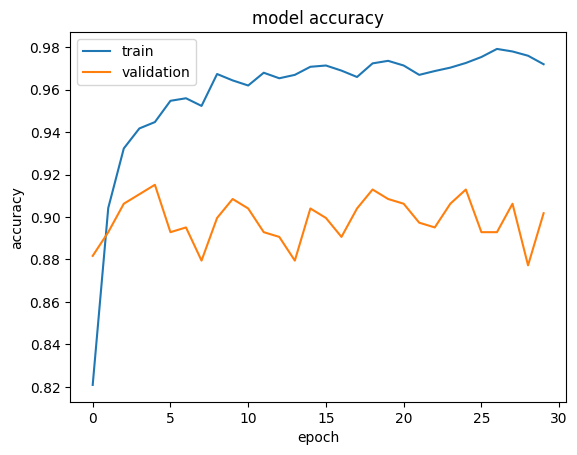

In [21]:
model_data_augument = efficientNetB0_model(num_classes=NUM_CLASSES, dropout=False, l2=False )
model_data_augument_output = model_data_augument.fit(ds_train_augumented, epochs=EPOCHS, validation_data=ds_valid_augumented)
plot_hist(model_data_augument_output)

In [25]:
def plot_hist_all(hist, hist1, hist2, hist3, hist4):
    plt.figure(figsize=(10, 6))  # Adjust figure size here
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist1.history["accuracy"])
    plt.plot(hist1.history["val_accuracy"])
    plt.plot(hist2.history["accuracy"])
    plt.plot(hist2.history["val_accuracy"])
    plt.plot(hist3.history["accuracy"])
    plt.plot(hist3.history["val_accuracy"])
    plt.plot(hist4.history["accuracy"])
    plt.plot(hist4.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    
    # Move legend outside the plot and adjust its position
    plt.legend(["Train-WOR", "Validation-WOR", "Train-L2", "Validation-L2", 
                "Train-Dropout", "Validation-Dropout", "Train-Ensemble", "Validation-Ensemble", "Train-Augumentation", "Validation-Augumentation"], 
               loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

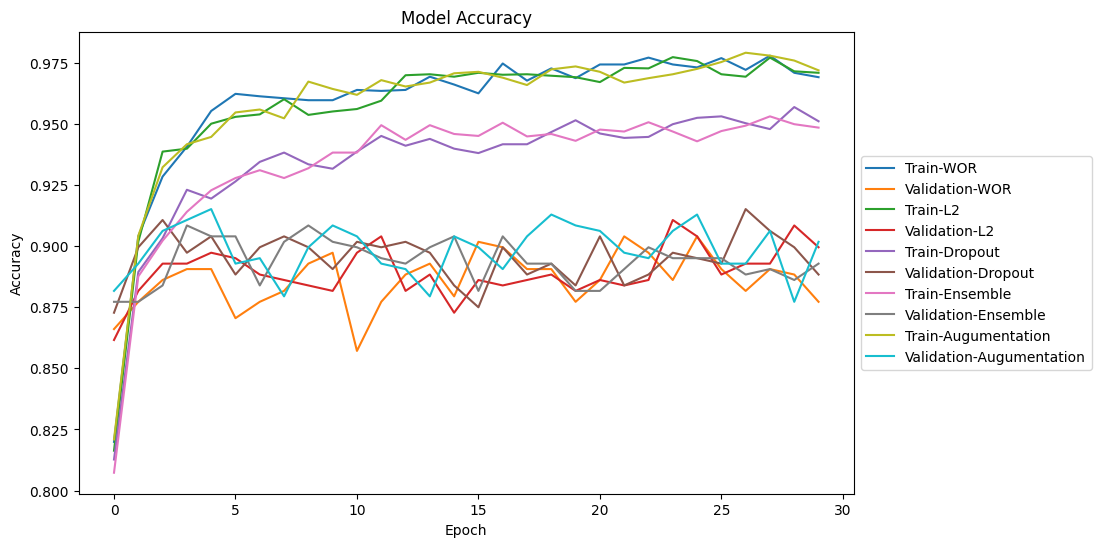

In [26]:
plot_hist_all(model_baseline_output, model_l2_output, model_dropout_output, model_ensemble_output, model_data_augument_output)

# Regularization Techniques for Dataset 1

In [ ]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#              - RandomErasing is concerned about removing and randomly adding information on the
#               blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#               Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 1 - applying RandomErasing and MaxDropout together. Applied to Dataset1.

# Dataset 2

In [ ]:
# 2. nltk-brown + nltk-treebank + nltk-conll2000
#   (a) Dataset Summary - The combination of these 3 datasets gives us a large corpus of
#                       textual data that can be used for training a model that performs sequence labeling with
#                       a total size of 72,000+ tagged sentences. The nltk library takes the base dataset and
#                       performs tokenization to prepare it for the task of sequence labeling.
#   (b) Data Feature Dimensions -
#         i. Input Sequence - A sentence in english.
#        ii. Output Sequence - POS tags of each word of the sentence.

In [ ]:
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('universal_tagset')


[nltk_data] Downloading package brown to
[nltk_data]     /Users/hrishikesh/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/hrishikesh/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/hrishikesh/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/hrishikesh/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
treebank = treebank.tagged_sents(tagset='universal')
brown = brown.tagged_sents(tagset='universal')
conll2000 = conll2000.tagged_sents(tagset='universal')
print(treebank[0])
print(brown[0])
print(conll2000[0])

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]
[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]
[('Confidence', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('pound', 'NOUN'), ('is', 'VERB'), ('widely', 'ADV'), ('expected', 'VERB'), ('to', 'PRT'), ('take', 'VERB'), ('another', 'DET'), ('sharp', 'ADJ'), ('dive', 'NOUN'), ('if

In [ ]:
def create_dataset(data):
    sentences = []
    pos_tags = []

    for sequence in data:
        sentence = []
        tags = []
        for seq in sequence:         
            sentence.append(seq[0])
            tags.append(seq[1])
            
        sentences.append(sentence)
        pos_tags.append(tags)
    return pd.DataFrame(zip(sentences, pos_tags), columns=["sentences", "pos_tags"])

In [ ]:
corpus_dataset = create_dataset(treebank + brown + conll2000)
corpus_dataset.head(5)

sentences  \
0  [Pierre, Vinken, ,, 61, years, old, ,, will, j...   
1  [Mr., Vinken, is, chairman, of, Elsevier, N.V....   
2  [Rudolph, Agnew, ,, 55, years, old, and, forme...   
3  [A, form, of, asbestos, once, used, *, *, to, ...   
4  [The, asbestos, fiber, ,, crocidolite, ,, is, ...   

                                            pos_tags  
0  [NOUN, NOUN, ., NUM, NOUN, ADJ, ., VERB, VERB,...  
1  [NOUN, NOUN, VERB, NOUN, ADP, NOUN, NOUN, ., D...  
2  [NOUN, NOUN, ., NUM, NOUN, ADJ, CONJ, ADJ, NOU...  
3  [DET, NOUN, ADP, NOUN, ADV, VERB, X, X, PRT, V...  
4  [DET, NOUN, NOUN, ., NOUN, ., VERB, ADV, ADJ, ...

# Regularization Techniques for Dataset 2

In [ ]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#       - RandomErasing is concerned about removing and randomly adding information on the
#         blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#         Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 2 - applying RandomSynonymReplacement and MaxDropout together. Applied to Dataset2.